In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import tensorflow as tf
print(tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


2.16.2
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
dataset_path = "./dataset/dataset/Uang Baru"

In [4]:
from pathlib import Path
from collections import Counter

dataset_path = Path(dataset_path)

In [5]:
paths = list(dataset_path.glob('*/*'))
classes = dict(Counter([path.parent.stem for path in paths]))
extensions = dict(Counter([path.suffix for path in paths]))
classes, extensions

({'20 K': 214,
  '100 RB': 227,
  '5k': 227,
  '50 K': 171,
  '10 k': 183,
  '1k': 184,
  '2k': 75},
 {'.jpeg': 1281})

In [6]:
# check dataset for non-jpg even though they have .jpg extension files:
from PIL import Image

formats = []
for path in paths:
    im = Image.open(path)
    formats.append(im.format)
    im.close()
    
Counter(formats)

Counter({'JPEG': 1281})

In [7]:
class Config:
    batch_size = 16
    img_dim = (224,224)
    epochs = 20

In [8]:
train_ds = keras.utils.image_dataset_from_directory(dataset_path,
                                                    subset = 'training',
                                                    validation_split = 0.2,
                                                    image_size = Config.img_dim,
                                                    batch_size = Config.batch_size,
                                                    seed=1
                                                   )

val_ds = keras.utils.image_dataset_from_directory(dataset_path,
                                                  subset = 'validation',
                                                  validation_split = 0.2,
                                                  image_size = Config.img_dim, 
                                                  batch_size = Config.batch_size,
                                                  seed=1
                                                 )

Found 1281 files belonging to 7 classes.
Using 1025 files for training.
Found 1281 files belonging to 7 classes.
Using 256 files for validation.


2025-07-01 00:25:57.991086: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-07-01 00:25:57.991235: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-01 00:25:57.991243: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-07-01 00:25:57.991452: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-01 00:25:57.991474: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(*Config.img_dim, 3)),
    layers.RandomContrast(0.2),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3)
  ]
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model = Sequential([
    Rescaling(1./255,  input_shape=(*Config.img_dim, 3)),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7)
])

In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 128)  │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 373248)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │    23,887,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,928,135 (91.28 MB)

 Trainable params: 23,928,135 (91.28 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer='adam', 
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    mode='max',
    restore_best_weights=True,
    verbose=1
)


In [17]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.9623 - loss: 0.1210 - val_accuracy: 0.6562 - val_loss: 1.2380
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.7665 - loss: 0.8474 - val_accuracy: 0.8555 - val_loss: 0.4908
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9512 - loss: 0.1684 - val_accuracy: 0.7695 - val_loss: 0.9766
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9687 - loss: 0.0696 - val_accuracy: 0.8711 - val_loss: 0.5062
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.9987 - loss: 0.0080 - val_accuracy: 0.8867 - val_loss: 0.3931
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.9023 - val_loss: 0.3755
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9102 - val_loss: 0.3615
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 7.6505e-04 - val_a

In [18]:
def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

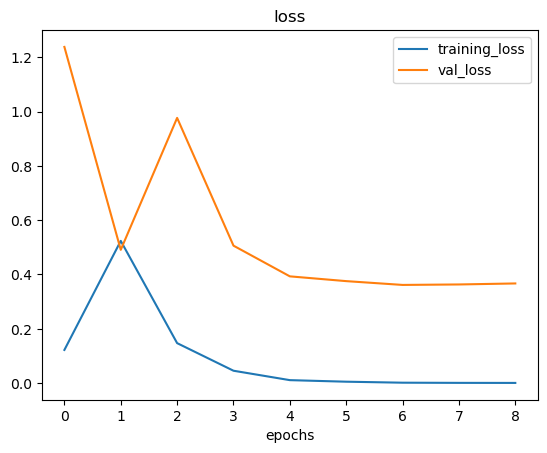

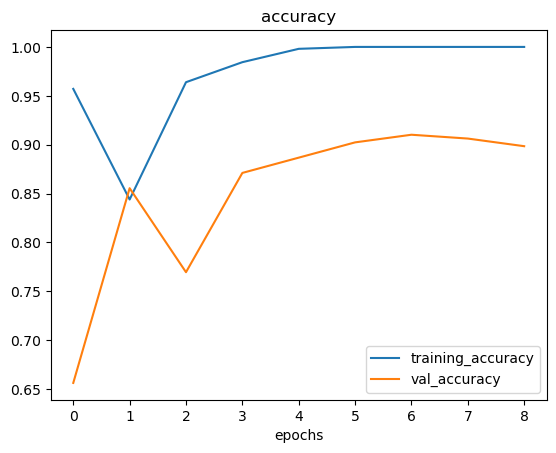

In [19]:
plot_loss_curves(history)

In [22]:
from PIL import Image
import numpy as np

def predict_image(image_path, model, class_names, img_dim=(224,224)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(img_dim)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    preds = model.predict(img_array)
    pred_class = np.argmax(preds, axis=1)[0]
    return class_names[pred_class], preds[0]

# Contoh penggunaan:
# Ambil nama kelas dari dictionary classes (urutkan sesuai urutan label pada dataset)
class_names = list(classes.keys())

# Ganti 'path_gambar_baru.jpeg' dengan path file gambar yang ingin diuji
predicted_class, probabilities = predict_image('./dataset/sampel/5k/UANG RUPIAH 5000 (1).jpeg', model, class_names, img_dim=Config.img_dim)
print("Predicted class:", predicted_class)
print("Probabilities:", probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class: 20 K
Probabilities: [ 72.00028  -38.902897 -14.758217  -6.611001 -51.121628 -26.808254
 -38.136574]


Found 1281 files belonging to 7 classes.


2025-07-01 00:47:44.445344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


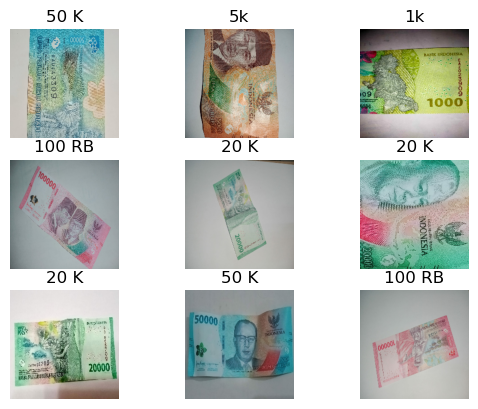

In [26]:
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path, 
    seed=42,
    image_size= Config.img_dim,
    batch_size=10
)
currency_nominal = dataset.class_names
num_of_classes = len(currency_nominal)
currency_nominal

for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(currency_nominal[labels[i]])
        plt.axis('off')

In [27]:
loss, accuracy = model.evaluate(dataset)
print('accuracy :', accuracy)
print('loss     :', loss)

129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9841 - loss: 0.0675
accuracy : 0.9820452928543091
loss     : 0.07303475588560104


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2025-07-01 00:48:24.664606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


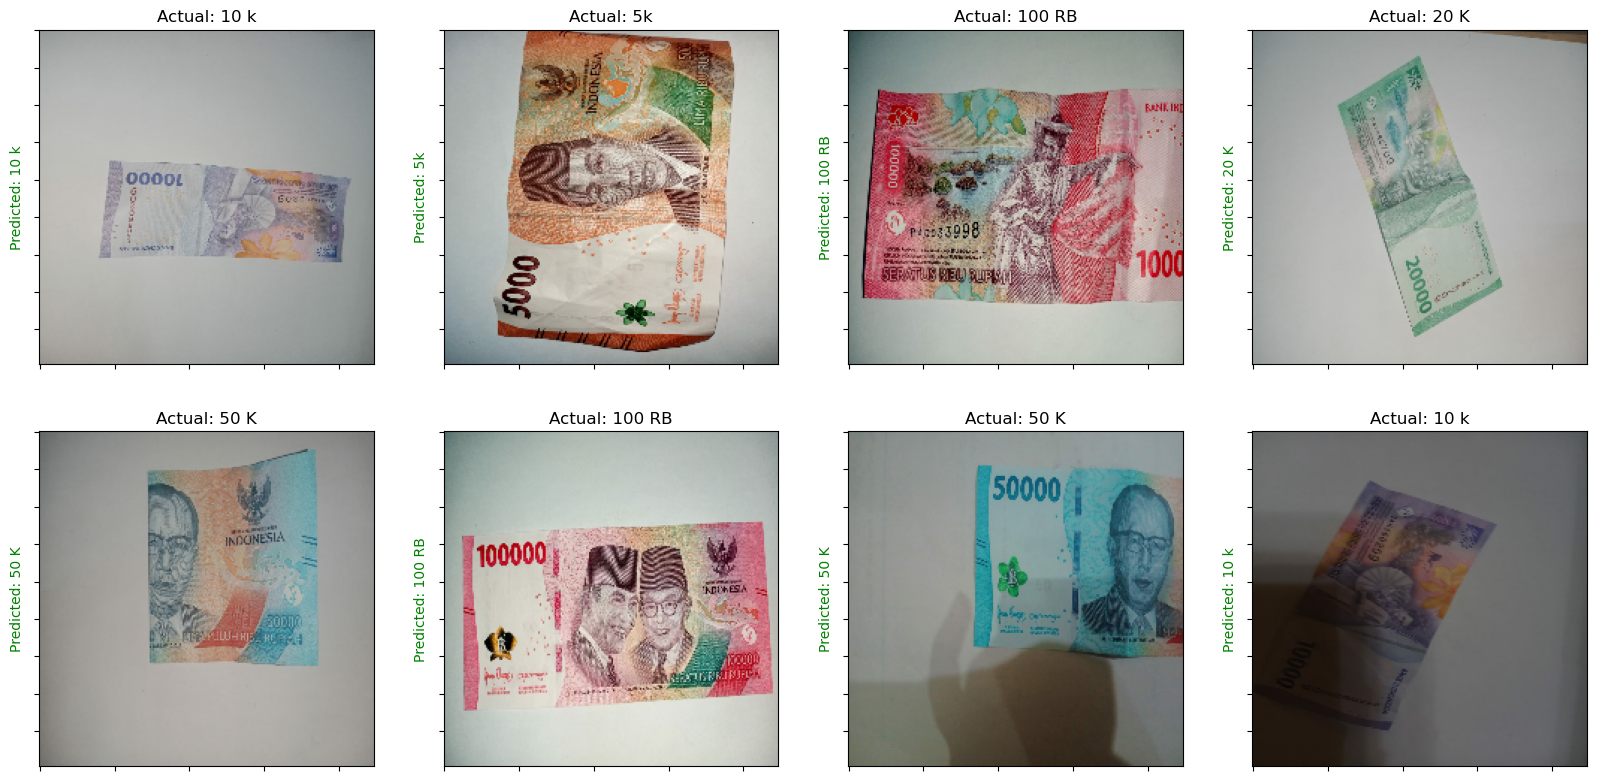

In [28]:
plt.figure(figsize=(20, 20))
for images, labels in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        
        predicted_axis_color = 'green' if currency_nominal[labels[i]] == currency_nominal[np.argmax(score)] else 'red'
        
        plt.title('Actual: ' + currency_nominal[labels[i]])
        plt.ylabel('Predicted: ' + currency_nominal[np.argmax(score)], fontdict={'color': predicted_axis_color})
          
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.gca().axes.yaxis.set_ticklabels([])

In [29]:
model.save('uang.h5')